## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Ногина Дарья

In [96]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [5]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/Users/daria/anaconda3/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [6]:
images_train, labels_train = next(iter(train_loader))

In [7]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

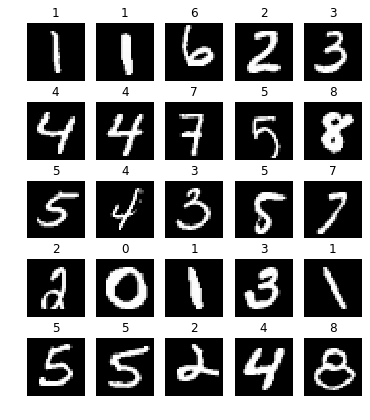

In [8]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [116]:
def init_layer(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=std)

def forward_hook(self, input_, output):
    std = input_[0].std().item()
    #print('forward', std)


def backward_hook(self, grad_input, grad_output):
    std = grad_input[0].std().item()
    backward_values.append(std)

    
# пример:
'''layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(get_storing_backward_hook)
init_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры'''

'layer = nn.Linear(28*28, 10)\nlayer.register_forward_hook(forward_hook)\nlayer.register_backward_hook(get_storing_backward_hook)\ninit_layer(layer, 0.0, 0.1) # сюда надо подставить другие параметры'

In [117]:
sizes = [28*28] + [500] * 10 + [10]
layers = []
for i, size in enumerate(sizes[:-1]):
    layer = nn.Linear(size, sizes[i+1])
    layer.register_forward_hook(forward_hook)
    layer.register_backward_hook(backward_hook)
    init_layer(layer, 0.0, 0.1)
    layers.append(layer)
    layers.append(nn.Tanh())
    
network = nn.Sequential(*layers)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [118]:
n_objects = 100
X = images_train[:n_objects].view(n_objects, -1).data
y = labels_train[:n_objects].data
backward_values = []
activations = network(X)
loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
loss = loss_fn(activations, y)
loss.backward()

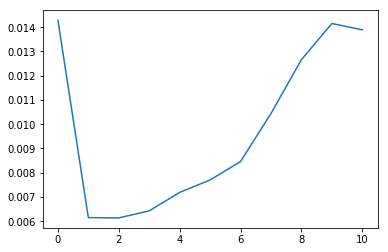

In [119]:
plt.plot(backward_values)

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

In [154]:
def xavier(size_input, size_output):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    u = np.sqrt(6 / (size_input + size_output))
    weight.uniform_(-u, u)
    
def he(size_input, size_output):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    weight.normal_(mean=0, std=2/size_input)

def build_network(sizes, initiation, activation):
    layers = []
    for i, size in enumerate(sizes[:-1]):
        layer = nn.Linear(size, sizes[i+1])
        layer.register_forward_hook(forward_hook)
        layer.register_backward_hook(backward_hook)
        initiation(size, sizes[i+1])
        layers.append(layer)
        layers.append(activation)
    return nn.Sequential(*layers)

def run_network(X, y, sizes, initiation, activation):
    network = build_network(sizes, initiation, activation)
    global backward_values
    backward_values = []
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()
    plt.plot(backward_values)

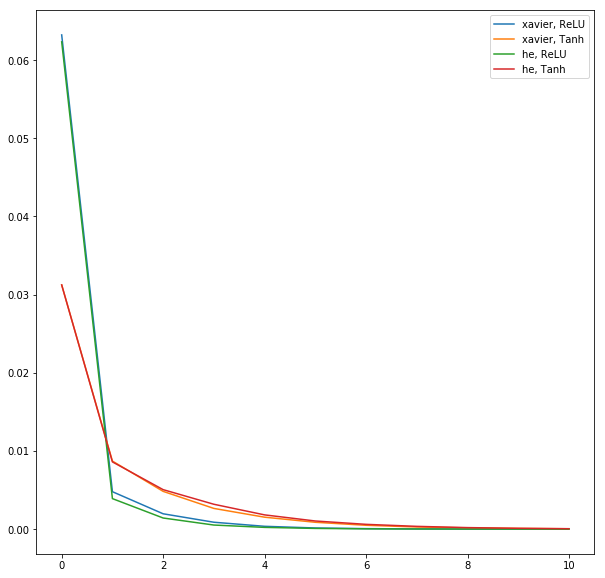

In [166]:
plt.figure(figsize=(10,10))
for initiation in [xavier, he]:
    for activation in [nn.ReLU(), nn.Tanh()]:
        run_network(X, y, sizes, initiation, activation)
plt.gca().legend(('xavier, ReLU', 'xavier, Tanh', 'he, ReLU', 'he, Tanh'))
plt.show()

<i> 1.4 Сделайте выводы по первой части </i>

Инициализация в данном примере не критично влияет на обучение, но видно, что для ReLU лучше подходит he, а для Tanh xavier (то есть, пример иллюстрирует теорию)

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [167]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [168]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

Epoch 9... (Train/Test) NLL: 0.050/0.069	Accuracy: 0.984/0.977


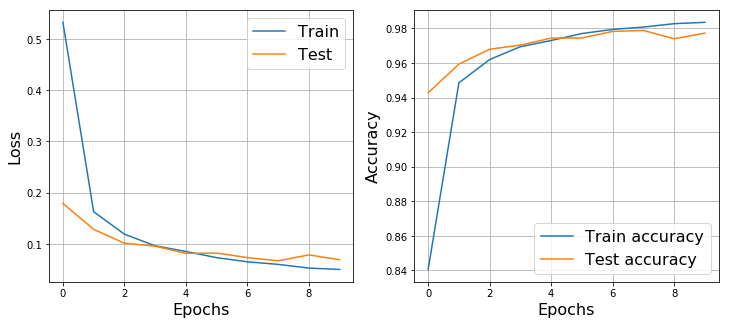

CPU times: user 5min 23s, sys: 23.2 s, total: 5min 46s
Wall time: 6min 12s


([0.5323146922724333,
  0.16269072867246834,
  0.11885920101439139,
  0.09612716507635263,
  0.08514141297932945,
  0.07303266875199609,
  0.06494607586167388,
  0.05987141146433792,
  0.052656971915527734,
  0.05000693432694829],
 [0.1788232156747504,
  0.12832342092938062,
  0.10118630144132089,
  0.09545591405203825,
  0.08132660989001204,
  0.08201489774392376,
  0.07314501166980289,
  0.06680291864867735,
  0.07842248977645289,
  0.06897817377024625],
 [0.8406072,
  0.9485386,
  0.9619758,
  0.9694163,
  0.9730089,
  0.97704005,
  0.97940546,
  0.9807603,
  0.982737,
  0.9835033],
 [0.9427413,
  0.95935524,
  0.96795887,
  0.97033226,
  0.9743869,
  0.97448575,
  0.97824365,
  0.978837,
  0.9739913,
  0.97725475])

In [174]:
%%time

#blank

layers = [
    nn.Linear(196, 128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

from train_utils import train

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.118/0.064	Accuracy: 0.965/0.979


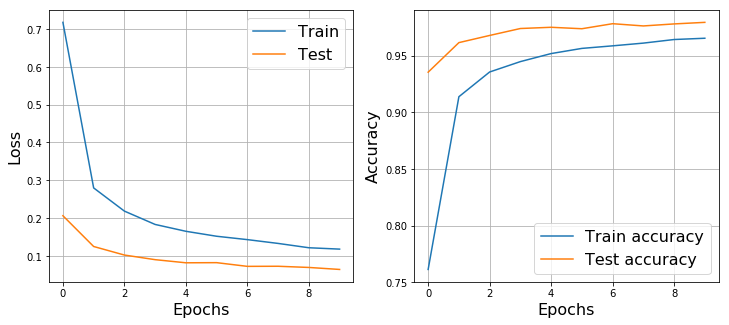

CPU times: user 5min 15s, sys: 24.7 s, total: 5min 39s
Wall time: 5min 37s


([0.717474826013864,
  0.2798954662737816,
  0.21861499708407978,
  0.18335589047656384,
  0.16527166278727018,
  0.15215895017549427,
  0.14324113766331154,
  0.13320535270453515,
  0.12177954031539752,
  0.11815355530282709],
 [0.20640949274212878,
  0.12509399455017114,
  0.1024937431174743,
  0.0902764143752335,
  0.08201906181683269,
  0.0823742351435785,
  0.07258412144087915,
  0.07285039457551475,
  0.0697044128127679,
  0.06443575577503896],
 [0.7611885,
  0.913746,
  0.9355899,
  0.94476277,
  0.951859,
  0.9564232,
  0.9586832,
  0.96109855,
  0.96426904,
  0.9653962],
 [0.93542325,
  0.96153086,
  0.96786,
  0.9739913,
  0.9750791,
  0.9737935,
  0.97824365,
  0.97626585,
  0.9780459,
  0.9794304])

In [177]:
%%time

#dropout
from train_utils import train

layers = [
    nn.Linear(196, 128),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.Dropout(p=0.5),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.193/0.112	Accuracy: 0.940/0.963


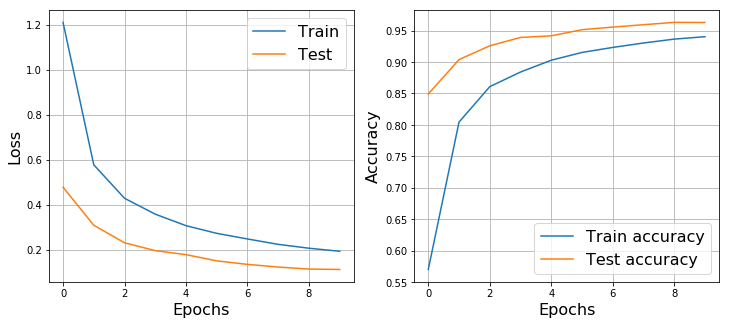

CPU times: user 3min 46s, sys: 21.1 s, total: 4min 7s
Wall time: 4min 11s


([1.210547764926577,
  0.5773443383321579,
  0.42859421340005993,
  0.35797346168870864,
  0.3067427313467587,
  0.27273637455091804,
  0.24770559286321403,
  0.22376843632411347,
  0.206568478918406,
  0.19309300718022815],
 [0.4777901119823697,
  0.3085384035035025,
  0.23076175860589063,
  0.19587549604947055,
  0.17801433476277545,
  0.1504194031033335,
  0.13473563117882872,
  0.12293907886818994,
  0.11382021472046647,
  0.11225706630362835],
 [0.5699682,
  0.804371,
  0.8607743,
  0.88408405,
  0.9028796,
  0.91522855,
  0.9232187,
  0.9302705,
  0.93643945,
  0.94028735],
 [0.8490902,
  0.9037777,
  0.9258307,
  0.93908226,
  0.9416535,
  0.95144385,
  0.9555973,
  0.95935524,
  0.9631131,
  0.96291536])

In [181]:
%%time

#dropconnect
from train_utils import train

layers = [
    DropConnect(196, 128),
    nn.ReLU(),
    DropConnect(128, 128),
    nn.ReLU(),
    DropConnect(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

При использовании Dropout и DropConnect accuracy немного падает, но зато видно, что модель меньше переобучается (точность на тесте становится выше, чем на трейне)

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [211]:
class LayerNormalization(nn.Module):
    def __init__(self, n_input, eps=1e-10):
        super(LayerNormalization, self).__init__()
        self.eps = eps
        self.n_input = n_input
        self.gain = nn.Parameter(torch.ones(self.n_input))
        self.bias = nn.Parameter(torch.zeros(self.n_input))
        
    def forward(self, x):
        y = (x - x.mean(-1, keepdim=True)) / (x.std(-1, keepdim=True) + eps)
        output = y * self.gain + self.bias
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

Epoch 9... (Train/Test) NLL: 0.019/0.045	Accuracy: 0.994/0.986


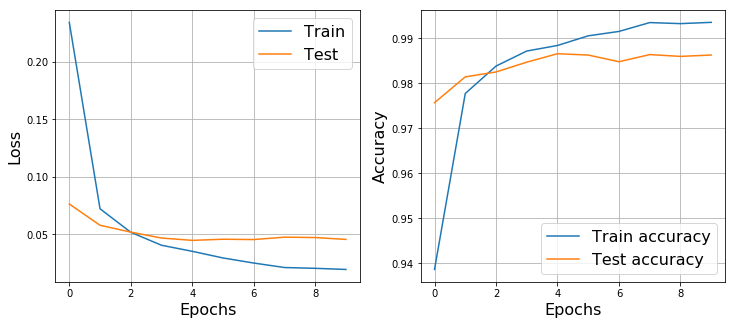

([0.23435822421950953,
  0.07189712840031141,
  0.051405316291214115,
  0.040099655037253365,
  0.03481852473256224,
  0.029027748433475904,
  0.024594166693635094,
  0.020689005038635466,
  0.019989168024070855,
  0.019014707903677066],
 [0.07605193369090557,
  0.057510124319056166,
  0.051550450457755144,
  0.046382568529040755,
  0.04435966129685882,
  0.0453419997356832,
  0.04506011508240164,
  0.04715057693221429,
  0.04681262868468331,
  0.04518441580342058],
 [0.93863827,
  0.9777119,
  0.9838031,
  0.9871457,
  0.9883784,
  0.9905217,
  0.991499,
  0.9934646,
  0.9932314,
  0.9935146],
 [0.9756725,
  0.98140824,
  0.982496,
  0.98467165,
  0.9865506,
  0.986254,
  0.9847706,
  0.98635286,
  0.98595726,
  0.986254])

In [183]:
# Batch normalization
layers = [
    nn.Linear(196, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

Epoch 9... (Train/Test) NLL: 0.026/0.051	Accuracy: 0.991/0.985


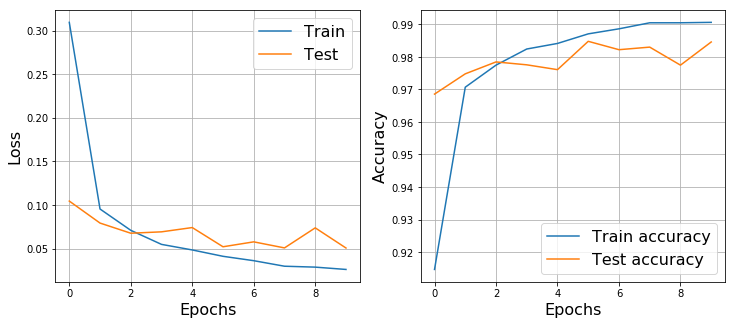

([0.30947774463593325,
  0.09535831892525336,
  0.07089757360517979,
  0.05477023542797101,
  0.048395056606157186,
  0.04109848125913202,
  0.03607119107792682,
  0.0297272950167587,
  0.028680325521509658,
  0.026025797080333982],
 [0.10445975450963914,
  0.07922803080063077,
  0.0675815984818943,
  0.06916941846190375,
  0.07408180430861591,
  0.05204407890221175,
  0.057679081365136026,
  0.05073271873090239,
  0.07373523786428231,
  0.05060213515417108],
 [0.91468436,
  0.9706768,
  0.9774565,
  0.98240936,
  0.9841196,
  0.98706245,
  0.9886116,
  0.99046624,
  0.9904717,
  0.99059945],
 [0.96855223,
  0.9747824,
  0.9784415,
  0.9775514,
  0.976068,
  0.9847706,
  0.9821994,
  0.9829905,
  0.9774525,
  0.98457277])

In [212]:
# Layer normalization
layers = [
    nn.Linear(196, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 128),
    LayerNormalization(128),
    nn.ReLU(),
    nn.Linear(128, 10)
]

network = TestNetwork(nn.Sequential(*layers))

train(network, train_loader, test_loader, 10, 0.001)

<i> 3.3 Сделайте выводы по третьей части </i>

На данном примере эффект не особо виден. В статье акцент на пользу layer normalization для рекуррентных нейросетей, где она стабилизирует скрытое состояние